# Tensorbard로 모델, 데이터 및 교육 시각화
1. 데이터를 읽고 적절한 변환 수행
2. TensorBard를 설정
3. TensorBoard에 씀
4. TensorBoard를 사용하여 모델 아키텍쳐를 검사
5. TensorBoard를 사용하여 시각화의 대화식 버전
    - __교육 데이터를 검사하는 몇 가지 방법__
    - __훈련하면서 모델의 성능을 추적하는 방법__
    - __훈련된 모델의 성능을 평가하는 방법__

## CIFAR10

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
                [transforms.ToTensor(), # tensor type으로 바꾸고
                 transforms.Normalize((0.5,), (0.5,)) # -1 ~ 1사이로 정규화
                ])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
                                             download=True,
                                             train=True,
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
                                            download=True,
                                            train=False,
                                            transform=transform
                                            )
# data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser',
           'Pullover', 'Dress',
           'Coat', 'Sandal',
           'Shirt', 'Sneaker',
           'Bag','Ankle Boot')

# show image def
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        # r g b 에 맞게 transpose해줌
        plt.imshow(np.transpose(npimg, (1,2,0)))

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## TensorBoard

### 텐서 보드 설정

In [3]:
from torch.utils.tensorboard import SummaryWriter
# default log_dir는 runs
writer = SummaryWriter('runs/fashion_mnist_experiment_1')
# pip install future

## 텐서 보드에 쓰기
- make_grid를 사용하여 이미지를 Tensorboard에 씀

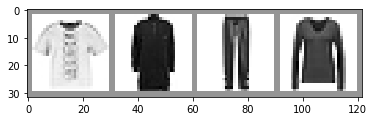

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

### 텐서보드에서 확인
- 커맨드라인에서 
    - tensorboard --logdir=runs
        - log가 있는 dir path를 --logdir인자로 넣어줌
            - 주의할점은 cmd 상의 경로를 기준으로 실행되기때문에 경로 확인필요

## 텐서보드를 사용하여 모델 검사
- 모델을 시각화

In [7]:
writer.add_graph(net, images)
writer.close()

## 텐서보드에 프로젝터 추가
- `add_embedding` 메서드를 통해 고차원 데이터의 저 차원 표현을 시각화

In [8]:
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    
    # 0에서 len(data)의 임의 순열
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(trainset.data, trainset.targets)

class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

## 텐서보드를 이용한 모델 훈련 추적
- 2000번의 반복마다 모델의 실행 손실을 인쇄 : `plot_classes_preds`함수를 통해 실행손실 기록

In [16]:
# helper functions

def images_to_probs(net, images):
    '''
        훈련된 모델로부터 예측확률 생성
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
       훈련된 모델을 통해 matplotlibs Figure 생성
       최고예측을 보여줌
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

__마지막으로__
- `add_scalar`함수를 사용해 loss graph를 텐서보드에서 볼 수 있도록 함

In [17]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 2000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


## 텐서보드로 훈련된 모델평가

In [18]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)